### This notebook is focused on how to make a DataFram for the Placemeter's sensors around New York City through their API and plot the results. Thus, It is necessarily to have Placemeter API token. 

In [19]:
%load_ext watermark
%watermark -v -m -p pandas,numpy

import json
import codecs

import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from datetime import date
from time import mktime

import uncurl
import requests

### A .txt file with the Placemeter API token should be placed with this code file
api_key = open('token.txt', 'r').read() 

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Bar, Scatter, Figure, Layout

from plotly.graph_objs import *
import numpy as np

import cufflinks as cf

print ("Plotly  ", __version__)
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline 


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.5.2
IPython 4.2.0

pandas 0.18.1
numpy 1.11.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Plotly   1.12.5


#### In the API, the following GET command is recommended for downloading the data. The command has to be converted to “requests.get ()” for use in python. 

In [10]:
uncurl.parse ('GET https://api.placemeter.net/api/v1/measurementpoints/id/data?start=start&end=end&resolution=resolution&metrics=metrics[&classes=classes][&include_unreliable_data=include_unreliable_data]')

'requests.get("https://api.placemeter.net/api/v1/measurementpoints/id/data?start=start&end=end&resolution=resolution&metrics=metrics[&classes=classes][&include_unreliable_data=include_unreliable_data]",\n    headers={},\n    cookies={},\n)'

In [11]:
r = requests.get("https://api.placemeter.net/api/v1/measurementpoints", headers={ "Authorization": api_key })
data = r.json()
df1 = pd.DataFrame.from_dict(data)
df1.head()

,classes,id,location,metrics,name,type
0,[all],14331,"{'latitude': 40.7198744, 'longitude': -74.0018...","[{'id': 'direction_1', 'name': 'Direction 1'},...",Broadway @ Canal - Street,turnstile
1,[all],14333,"{'latitude': 40.7198744, 'longitude': -74.0018...","[{'id': 'direction_1', 'name': 'Direction 1'},...",Canal Subway NQR,doorway
2,[all],14332,"{'latitude': 40.7198744, 'longitude': -74.0018...","[{'id': 'direction_1', 'name': 'Direction 1'},...",Broadway @ Canal - West Sidewalk,turnstile
3,[all],17204,"{'latitude': None, 'longitude': None}","[{'id': 'direction_1', 'name': 'Direction 1'},...",Canal South Half?,turnstile
4,[all],17205,"{'latitude': None, 'longitude': None}","[{'id': 'direction_1', 'name': 'Direction 1'},...",Area 1,None


#### There are tree active demo sensors with id of ‘14331’, ‘14332’, ‘14333’. In the following the data from these sensors is going to be collected and plotted.  

In [12]:
main_df = pd.DataFrame()

## Sensor IDs
idnumber = '14333', '14331', '14332' 

## Starting day for collecting data.
start = date(2016, 6, 1) 
start =int(mktime(start.timetuple())) 

## End day for collecting data.
end = date(2016, 8, 16) 
end =int(mktime(end.timetuple()))

#### The following for loop is for getting the data and fill the main_df with the data from each sensor and convert the Unix timestamp to NYC time. 

In [13]:
for sensors in idnumber:
    query  = "https://api.placemeter.net/api/v1/measurementpoints/"+sensors+"/data?start="+str(start)+"&end="+str(end)
    r = requests.get(query, headers={ "Authorization": api_key })
    data= r.json()
    df = pd.DataFrame.from_dict(data['data'])
    df.rename(columns={'unreliable_periods':str(sensors)+'_unreliable_periods', 
                       'timestamp':str(sensors)+'_timestamp',
                       'all':str(sensors)+'_all'}, inplace=True)
    
    df3 = pd.DataFrame(columns= [str(sensors)+'_direction1', str(sensors)+'_direction2'])
    
    for (i,r) in df.iterrows():
        e = r[str(sensors)+'_all']
        df3.loc[i] = [e['direction_1'], e['direction_2']]
    
    df = pd.concat([df, df3], axis =1)
    df = df[[str(sensors)+'_timestamp', str(sensors)+'_unreliable_periods', str(sensors)+'_direction1', str(sensors)+'_direction2']]
    
    df[ str(sensors)+'_timestamp'] = pd.to_datetime(df[ str(sensors)+'_timestamp'], unit='s')
    df = df.set_index( str(sensors)+'_timestamp').tz_localize('UTC').tz_convert('America/New_York').tz_convert(None).reset_index()
    df.set_index( str(sensors)+'_timestamp', inplace = True)
    df.index = df.index - DateOffset(hours = 4) 
    
    if main_df.empty:
        main_df = df
    else:
        main_df = main_df.join(df)

    

#### Unfortunately, Github dose not render iplot yet, so I have added couple of screenshot from the plot. 

In [14]:
        
iplot(main_df.iplot(asFigure=True,
                        kind='scatter',xTitle='Dates',yTitle='Number of People',title='All the sensors'))

<img src="fig1.png">
<img src="fig2.png">


In [22]:
 import seaborn as sns

UnboundLocalError: local variable 'x' referenced before assignment

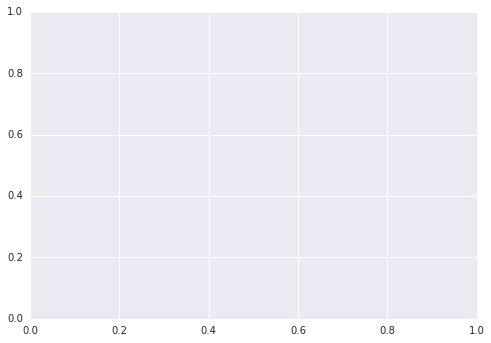

In [23]:
ax = sns.tsplot(data=main_df)

In [28]:
from ggplot import *

In [29]:
ggplot(data = main_df)

TypeError: __init__() missing 1 required positional argument: 'aesthetics'

In [30]:
from ggplot import meat
meat_lng = pd.melt(meat, id_vars=['date'])

In [31]:
meat_lng.head()

,date,variable,value
0,1944-01-01,beef,751.0
1,1944-02-01,beef,713.0
2,1944-03-01,beef,741.0
3,1944-04-01,beef,650.0
4,1944-05-01,beef,681.0


AttributeError: 'FigureCanvasAgg' object has no attribute 'invalidate'

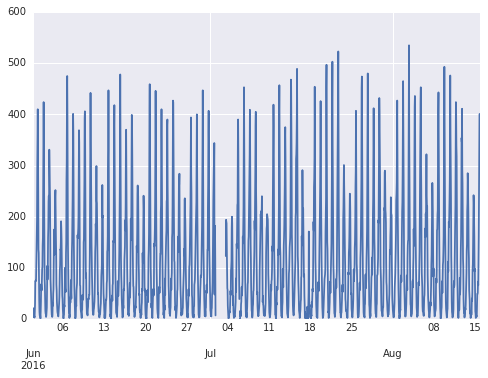

In [33]:
plt.figure(); main_df.plot();